### Optimizing Machine Learning Models

Goal: Start with a standard linear regression model and walk through machine learning tasks to improve/optimiize the model to predict the extent of fire damage to a forest.

Data: [Forest Fires UCI Machine Learning Repostiory](https://archive.ics.uci.edu/dataset/162/forest+fires)

Optimizing tools (see lessons):
1. Feature Engineering
    - Imputation, Outlier Detection, Box Plots, Z-Scores, Downsampling, Upweighting
2. Model Selection
    - Sequential Feature Selection, Forward Selection, Backward Selection, criteria for comparing (AIC, BIC, R^2)
3. Cross Validation
    - K-fold cross validation, LOOCV, Bias, Variance, Bias-Variance trade off
4. Regularization
    - Ridge Regression, LASSO, Standardization so that each of the coefficients after standarxization are penalized efficiently
5. Going Beyond Linear models
    - (Polynomial models adding powers to help explain non-linear trends), Piecewise functions, knots, spline models
    

### Import libraries and Load Data

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [34]:
# Load in the fires dataset
fires = pd.read_csv("fires.csv")

# The reference model will only use temp and wind as features, so keep that in mind for later.
# The outcome of interest is the area column, which represents the total area damaged by the fire.

fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

# Finally, instantiate a new LinearRegression() object to hold this reference model for evaluation later.
reference = LinearRegression()

#Examine info about data
fires.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


[Variable Information](https://archive.ics.uci.edu/dataset/162/forest+fires)


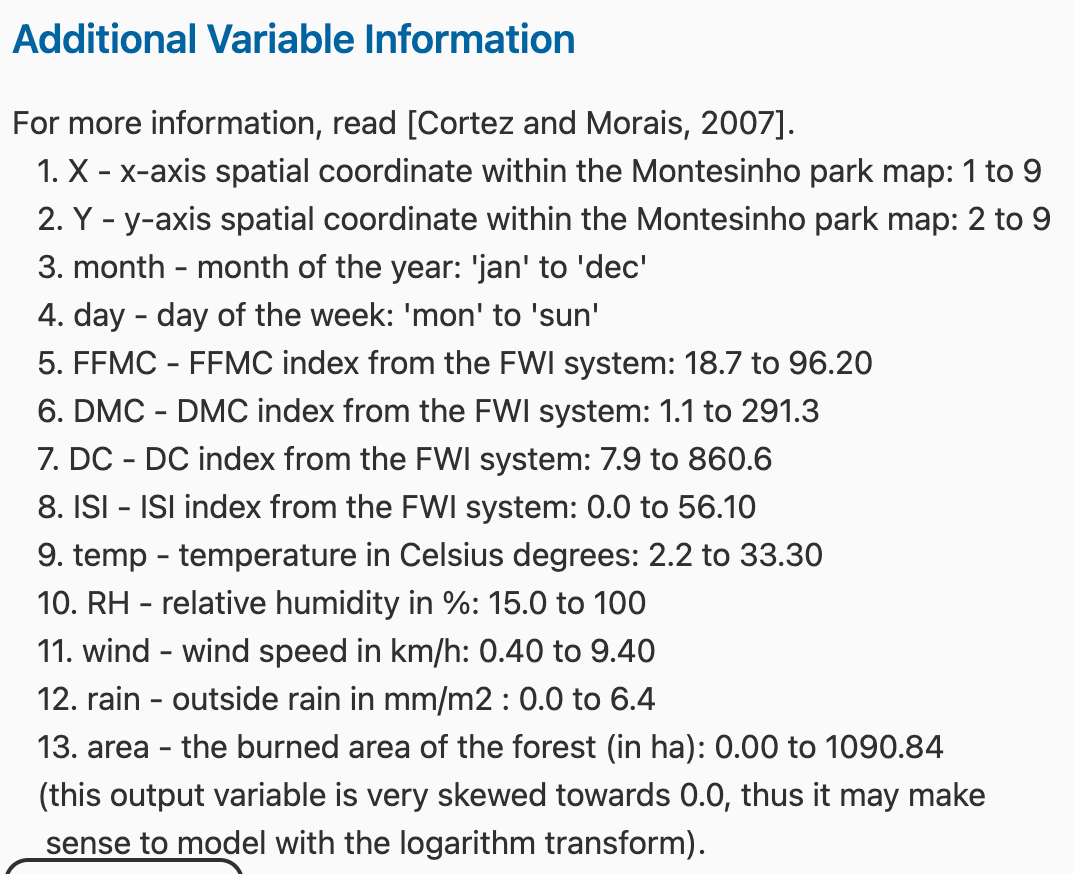

In [35]:
#Eamine first 5 rows
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [36]:
#Examine missing value counts within each column by this loop

for col in fires.columns:
    num_na = sum(pd.isna(fires[col]))
    print(f"The {col} column has {num_na} missing values.")

The Unnamed: 0 column has 0 missing values.
The X column has 0 missing values.
The Y column has 0 missing values.
The month column has 0 missing values.
The day column has 0 missing values.
The FFMC column has 48 missing values.
The DMC column has 21 missing values.
The DC column has 43 missing values.
The ISI column has 2 missing values.
The temp column has 21 missing values.
The RH column has 30 missing values.
The wind column has 35 missing values.
The rain column has 32 missing values.
The area column has 0 missing values.


### Data Pre-Processing

there is a considerable amount of missing data. Before you proceed with any model building or fitting, you should address the missing data first. It's tempting to rush through the data cleaning step, but we emphasize the importance of understanding the data and properly processing it.

Often, the data we have on hand is the only thing we'll get, so we have to make the most of it. The more thoroughly we clean the data, the less frustration we'll experience when we actually perform the modeling. 

First, we'll convert the `month` column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

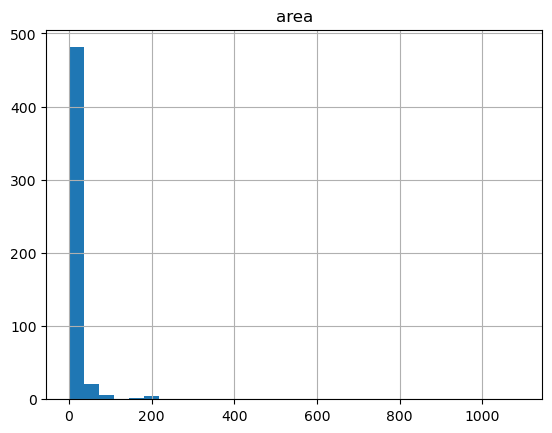

In [37]:
#Examine the area column which is the target column to predict.

fires.hist('area', bins=30)

The area column is the area that is damaged. The variable in the dataset does recomend to scale it by applying a log transformation due to the skewed nature of the dataset.

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero.

It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add `1` to prevent any errors. Recall that $log(0)$ is undefined.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

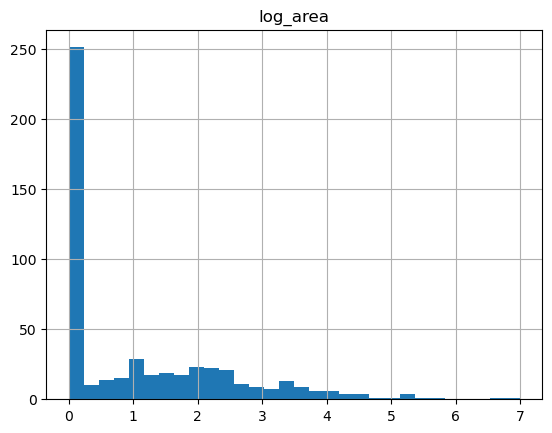

In [38]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

###### Side note on log transformation:
###### How many of one number multiply together to make another number?
###### E.g. 2 x 2 x 2 = 8, so we had to multlipy 3 of the 2s to get 8. So the logarithm is 3.
###### log(base 2) of 8 = 3
###### log(base 10) of 1000 = 3
###### log(base e) of 1.0986122886681098 = 3



We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows. 

Instead of using `month` directly, we'll derive another feature called `summer` that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely. 

In [39]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = [is_summer_month(m) for m in fires["month"]]

In [40]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain columns
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


In [41]:
#verify imputes transforemd the missing values
imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


<AxesSubplot:>

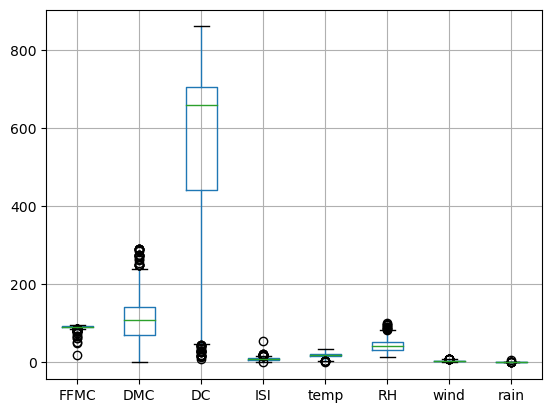

In [42]:
# Examine the data for outliers using boxplots.

imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])

The dots indicate that there are some outliers in the data. Let's examine the number of outliers in each of the columns.

In [43]:
for col in imputed:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


Despite the visual cue in the boxplots, based on the actual calculations, there don't seem to be any outliers. In this case, we'll leave the dataset as-is.

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it. These standardized values will help for standardization. Afterwards, we'll append the summmer feature back into the dataset.

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires["summer"], scaled], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


### Subset Selection
Now that we have a cleaned dataset with all numerical features and we've visually explored feature-outcome relationships, we can start modeling. There are quite a few features in the dataset, so let's use feature selection to determine which features might be useful for generating predictions. This is a purely data-driven approach to choosing a model based on feature importance, so it can help inform our process for creating an intial model that we can improve upon.

In [45]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [46]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Based on the features chosen by forward and backward selection, it seems like `DC`, `wind` and `FFMC` seem to be the most impactful on predicting `log_area`.

In [47]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)

### More Candidate Models

Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. There are such models; however, they were beyond the scope of the course, but they might be plausible candidates for further next steps.

In [48]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1372.2342342342342
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.

In [49]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  1371.3713713713714


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

### K-Fold Cross-Validation

In [50]:

from sklearn.model_selection import cross_val_score 

reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")

In [51]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))


Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Forward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795958
Backward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Backward-6 Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343
Ridge Model, Avg Test MSE:  -2.2397225539348753  SD:  1.0123323877770343


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.